In [1]:

import time

import matplotlib.pyplot as plt
import torch
from IPython.core.display import clear_output
from torch.nn import functional as F
from torch.optim import Adam

from environments import PendulumEnv
from environments.pendulum import State
from environments.pendulum.state import size as state_size
from evaluators.direct_actor import SWITCH, NOP
from shared_parameters import *
from utils import MLP, EpsilonDecay, MemoryBuffer, running_average

In [2]:
env = PendulumEnv(step_reward=1.0, action_cost=0.1, death_cost=100.0)

x = enemy_x


def get_starting_state():
    return State(bob_radius=bob_radius, max_angle=max_angle, connector_length=0.4, vertical_speed=0.05,
                 current_angle=current_angle, position=position, angular_speed=0.25,
                 enemy_radius=enemy_radius, enemy_x=x, enemy_y=enemy_y)

Let's define a NN.

Maps $state \times action \rightarrow \text{Q-value}$

In [3]:
num_actions = 2

q_net = MLP(state_size, num_actions, [6, 8, 4])

optim = Adam(q_net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 100)

sample_input = torch.from_numpy(get_starting_state()).unsqueeze(0)
print("Sample input:")
print(sample_input)

sample_q_values = q_net(sample_input)
print()
print("Sample Q-values:")
print(sample_q_values)

Sample input:
tensor([[0.1000, 0.8727, 0.4000, 0.0500, 0.0000, 0.0000, 0.2500, 0.1000, 0.1000,
         0.2500]])

Sample Q-values:
tensor([[-0.4940,  0.3070]], grad_fn=<AddmmBackward>)


How to train your dqn?

Predictions should correspond with the total discounted rewards.

In [4]:
from environments.pendulum.state import enemy_x as s_enemy_x
from random import random

max_episode_length = 20

q_net = MLP(state_size, num_actions, [6, 8, 4])
optim = Adam(q_net.parameters(), lr=0.01)

# Create a target network as well
target_q_net = MLP(state_size, num_actions, [6, 8, 4])
for p, p_target in zip(q_net.parameters(), target_q_net.parameters()):
    p_target.data = p.data
    p_target.requires_grad = False

polyak = 0.95

# Default starting state
start_state = get_starting_state()

memory = MemoryBuffer(capacity=10000)

# Epsilon for epsilon greedy strategy
epsilon = EpsilonDecay(iterations=1000)

discount = 0.995
epoch = 1


def train(verbose=False):
    global epoch
    training_sample = memory.sample(500)

    states, actions, rewards, next_states, dones = zip(*training_sample)

    states = torch.tensor(states)
    next_states = torch.tensor(next_states)
    dones = torch.tensor(dones).unsqueeze(-1)
    rewards = torch.tensor(rewards).unsqueeze(-1)

    q = q_net(states)
    q = q[range(q.shape[0]), actions].unsqueeze(-1)

    v = target_q_net(next_states).max(dim=-1, keepdim=True)[0]

    y = rewards + dones * discount * v

    loss = F.mse_loss(q, y)

    optim.zero_grad()
    loss.backward()
    optim.step()

    # Update target q net with polyak averaging
    for p, p_target in zip(q_net.parameters(), target_q_net.parameters()):
        p_target.data = p_target.data * polyak + p.data * (1 - polyak)

        # Updated epsilon
    epsilon.decay()

    if verbose:
        print(f"E. {epoch} Loss: {loss.item()}. Epsilon: {epsilon.value:>5.4f}")

    epoch += 1


total_rewards = []


def play_episode(render=False):
    episode = []

    # Randomize enemy position
    state = start_state
    state[s_enemy_x] = random() * (0.3 - -0.3) + -0.3

    step = 0
    done = False
    total_reward = 0
    while not done and step < max_episode_length:
        if render:
            env.render(state)
            time.sleep(0.01)

        q_values = q_net(torch.from_numpy(state))

        if random() < epsilon.value:
            action = NOP if random() > 0.5 else SWITCH
        else:
            action = torch.argmax(q_values).item()

        next_state, reward, done = env.transition(state, action)

        memory.push((state, action, reward, next_state, done))
        total_reward += reward

        if memory.is_full:
            train(step == 0)

        state = next_state

        step += 1

    clear_output(True)
    total_rewards.append(total_reward)
    if len(total_rewards) > 1000:
        total_rewards.pop(0)

    print(f"Total reward: {total_reward}. Total average: {sum(total_rewards) / len(total_rewards)}")
    return episode


while not memory.is_full:
    episode = play_episode()

try:
    train(verbose=True)
except KeyboardInterrupt:
    ...

Total reward: 18.9. Total average: -65.86186335403728
E. 3 Loss: 620.0148315429688. Epsilon: 0.9980


Total reward: 18.1. Total average: 6.6065000000000085


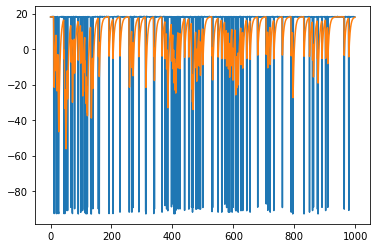

In [19]:
try:
    for i in range(100):
        play_episode(False)

    plt.plot(total_rewards)
    plt.plot(running_average(total_rewards))
    plt.show()
except KeyboardInterrupt:
    ...